### The code is continuation of the notebook **baseline.ipynb**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as functional
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


import pandas as pd
import matplotlib.pyplot as plt
#from model import Model
import numpy as np

In [ ]:
batch_size = 32
train_set = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#train_loader = DataLoader(dataset = train_set, batch_size= batch_size, shuffle = True)


#Creating validation set and training sets


index = list(range(len(train_set)))

#Train Set has size 60000, so we create validation set of size 10%
#print(index)
np.random.shuffle(index)
#print(index)
train_split = int(np.floor(0.9*60000))
#print(train_split)

training_set = Subset(train_set,index[:train_split])
validation_set = Subset(train_set,index[train_split:])
#print(len(training_set))
#print(len(validation_set))

training_loader = DataLoader(dataset=training_set,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size,shuffle=True)


# Creating test set
test_set = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
print("The size of training set is :",len(training_set))
print("The size of validation set is :",len(validation_set))
print("The size of testing set is :",len(test_set))

The size of training set is : 54000
The size of validation set is : 6000
The size of testing set is : 10000


torch.Size([32, 1, 28, 28])


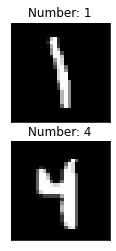

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

fig = plt.figure()
for i in range(2):
  plt.subplot(2,1,i+1)
  plt.imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Number: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self,p=0):
        super(CNN_Net,self).__init__()
        self.layers1 = nn.Sequential(
        nn.Conv2d(1,12,kernel_size=3,stride=1,padding=1),
        #nn.BatchNorm2d(10),
        nn.ReLU(inplace=True),
        nn.Dropout(p=p),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
        #nn.BatchNorm2d(30),
        nn.ReLU(inplace=True),
        nn.Dropout(p=p),
        nn.MaxPool2d(kernel_size=2,stride=2)
      )
        self.layers2 = nn.Sequential(
          nn.Linear(in_features=24*7*7,out_features=64),
          nn.ReLU(),
          nn.Dropout(p=p),
          nn.Linear(in_features=64, out_features=10),
      )
    
    def forward(self,x):
        x=self.layers1(x)
        x=x.view(x.size(0),-1)
        x=self.layers2(x)
        return x


# Xavier-Glorot initialization of weights  
def glorot_weights(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
model1 = CNN_Net(p=0.25)
model1.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer1 = optim.SGD(momentum=0.9,lr=0.01,params=model1.parameters())

lr_scheduler1 = optim.lr_scheduler.StepLR(optimizer=optimizer1 , step_size=10, gamma=0.1)

In [ ]:
model2 = CNN_Net(p=0.5)
model2.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer2 = optim.SGD(momentum=0.9,lr=0.05,params=model2.parameters())

lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer=optimizer2 , step_size=10, gamma=0.1)

In [ ]:
model3 = CNN_Net(p=0.75)
model3.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer3 = optim.SGD(momentum=0.9,lr=0.05,params=model3.parameters())

lr_scheduler3 = optim.lr_scheduler.StepLR(optimizer=optimizer3 , step_size=10, gamma=0.1)

In [ ]:
print("Training the CNN Model for p = 0.25:")
number_of_epochs = 50
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss1 = []
avg_training_accuracy1 = []

avg_validation_loss1 = []
avg_validation_accuracy1 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model1.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer1.zero_grad()
        
        output = model1(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer1.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy1.append(np.mean(batch_accuracy))
    avg_training_loss1.append(training_loss/(i+1))
    
    model1.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model1(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy1.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss1.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model1.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler1.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy1)
    print("\nTraining Loss :",avg_training_loss1)
    
    print("\nValidation Accuracy :",avg_validation_accuracy1)
    print("\nValidation Loss :",avg_validation_loss1)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy1))
print("\nThe average training loss is :",np.mean(avg_training_loss1))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy1))
print("\nThe average validation loss is :",np.mean(avg_validation_loss1))

Training the CNN Model for p = 0.25:
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.8891254443127962]

Training Loss : [0.34108001070722754]

Validation Accuracy : [0.9742353723404256]

Validation Loss : [0.10748670558306447]

Epoch is : 2

Training Accuracy : [0.8891254443127962, 0.9215325088862559]

Training Loss : [0.34108001070722754, 0.14831014829456046]

Validation Accuracy : [0.9742353723404256, 0.9762300531914894]

Validation Loss : [0.10748670558306447, 0.08143085068923996]

Epoch is : 3

Training Accuracy : [0.8891254443127962, 0.9215325088862559, 0.9361794036334913]

Training Loss : [0.34108001070722754, 0.14831014829456046, 0.11455136416515807]

Validation Accuracy : [0.9742353723404256, 0.9762300531914894, 0.9768395390070922]

Validation Loss : [0.10748670558306447, 0.08143085068923996, 0.07475902572858761]

Epoch is : 4

Training Accuracy : [0.8891254443127962, 0.9215325088862559, 0.9361794036334913, 0.944

The curves for losses of training data and validation data for p=0.25 are :


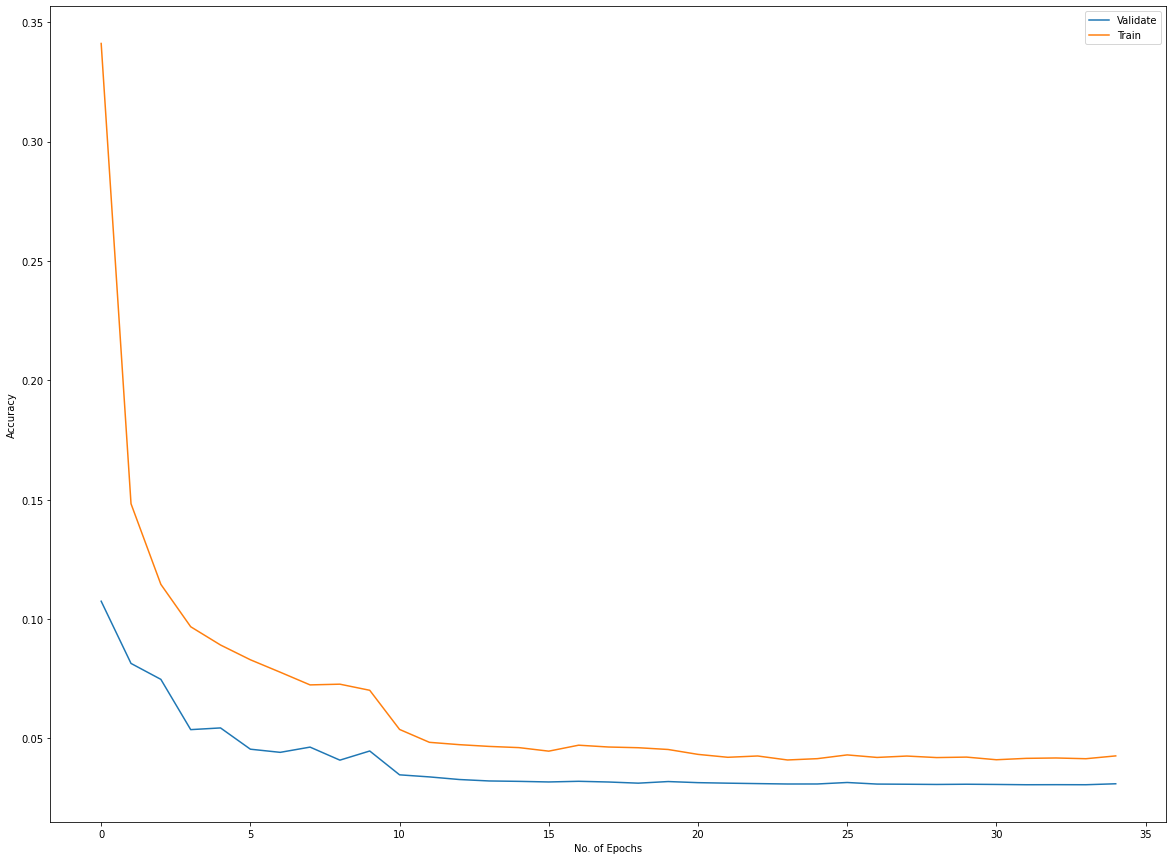

In [ ]:
print("The curves for losses of training data and validation data for p=0.25 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss1,label="Validate")
plt.plot(avg_training_loss1,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for p=0.25 are :


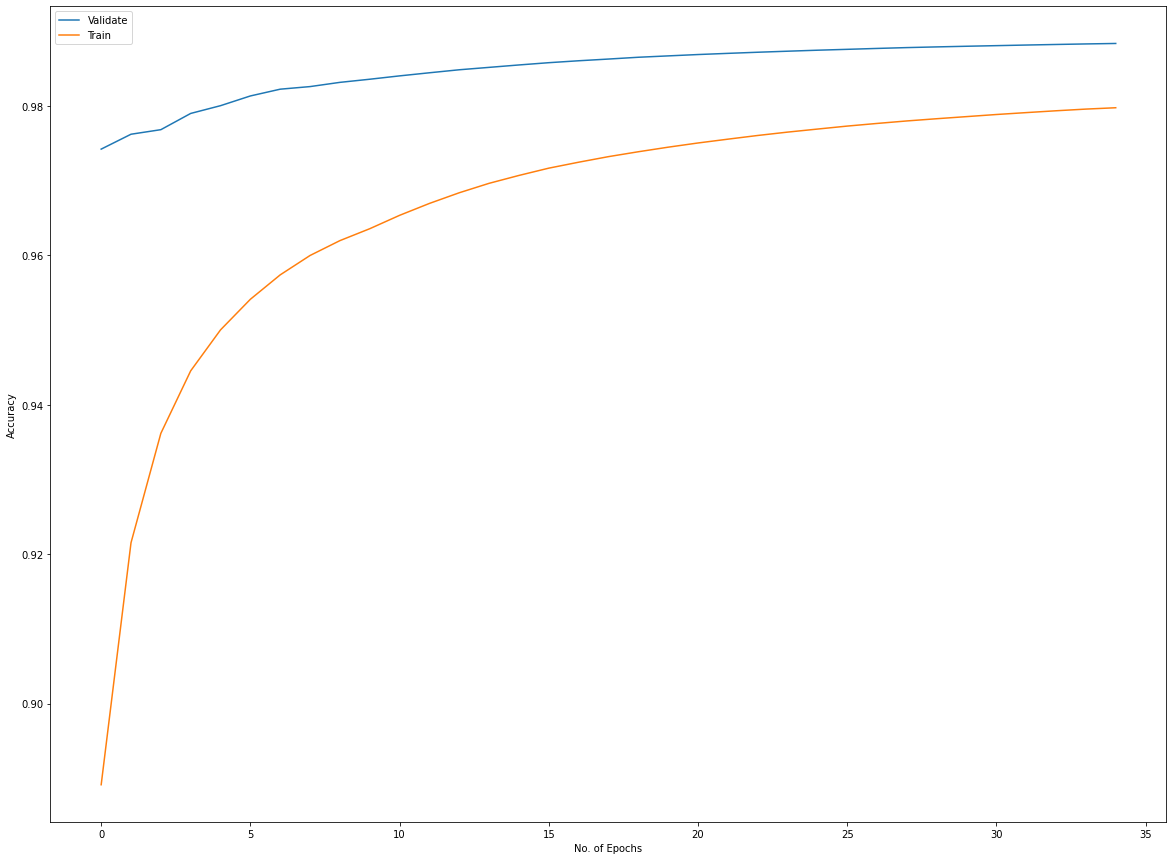

In [ ]:
print("The curves for accuracy of training data and validation data for p=0.25 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy1,label="Validate")
plt.plot(avg_training_accuracy1,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training the CNN Model for p = 0.5:")
number_of_epochs = 15
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss2 = []
avg_training_accuracy2= []

avg_validation_loss2 = []
avg_validation_accuracy2 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model2.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer2.zero_grad()
        
        output = model2(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer2.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy2.append(np.mean(batch_accuracy))
    avg_training_loss2.append(training_loss/(i+1))
    
    model2.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model2(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy2.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss2.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model2.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler2.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy2)
    print("\nTraining Loss :",avg_training_loss2)
    
    print("\nValidation Accuracy :",avg_validation_accuracy2)
    print("\nValidation Loss :",avg_validation_loss2)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy2))
print("\nThe average training loss is :",np.mean(avg_training_loss2))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy2))
print("\nThe average validation loss is :",np.mean(avg_validation_loss2))

Training the CNN Model for p = 0.5:
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.18427873222748814]

Training Loss : [2.1519072090068136]

Validation Accuracy : [0.11353058510638298]

Validation Loss : [2.30561958855771]

Epoch is : 2

Training Accuracy : [0.18427873222748814, 0.14433686315165878]

Training Loss : [2.1519072090068136, 2.304925656996632]

Validation Accuracy : [0.11353058510638298, 0.1068816489361702]

Validation Loss : [2.30561958855771, 2.304295134037099]

Epoch is : 3

Training Accuracy : [0.18427873222748814, 0.14433686315165878, 0.13149807464454977]

Training Loss : [2.1519072090068136, 2.304925656996632, 2.3049563492926377]

Validation Accuracy : [0.11353058510638298, 0.1068816489361702, 0.10272606382978723]

Validation Loss : [2.30561958855771, 2.304295134037099, 2.3074461386558855]

Epoch is : 4

Training Accuracy : [0.18427873222748814, 0.14433686315165878, 0.13149807464454977, 0.1246158545616

The curves for losses of training data and validation data for p=0.5 are :


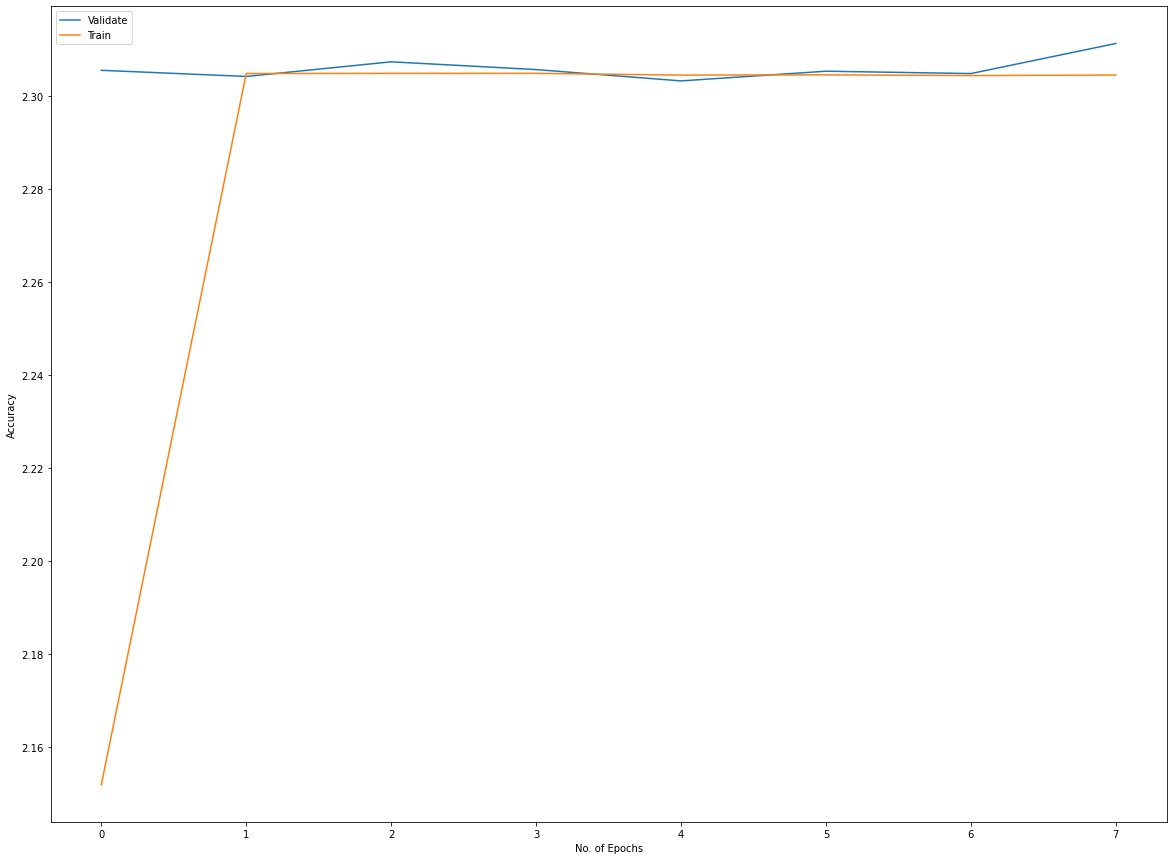

In [ ]:
print("The curves for losses of training data and validation data for p=0.5 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss2,label="Validate")
plt.plot(avg_training_loss2,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for p=0.5 are :


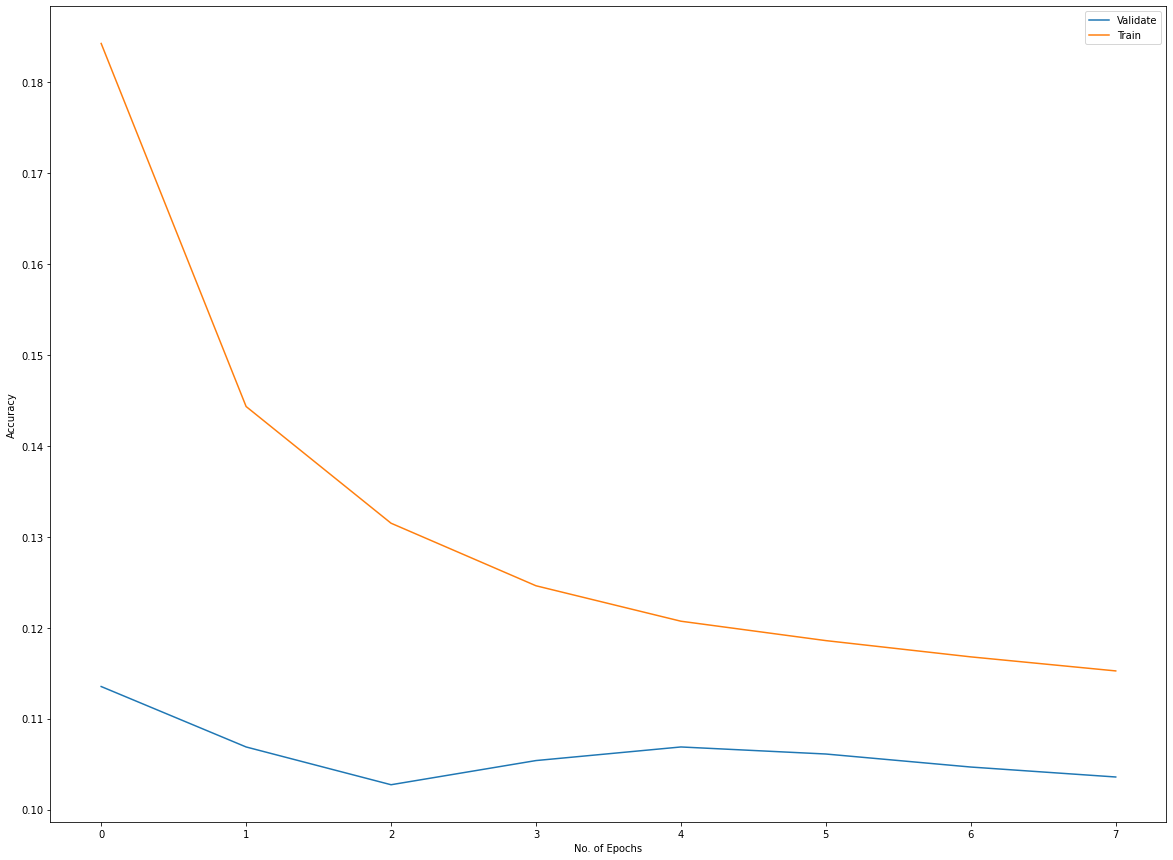

In [ ]:
print("The curves for accuracy of training data and validation data for p=0.5 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy2,label="Validate")
plt.plot(avg_training_accuracy2,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Training the CNN Model for p = 0.75:")
number_of_epochs = 15
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss3 = []
avg_training_accuracy3 = []

avg_validation_loss3 = []
avg_validation_accuracy3 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model3.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer3.zero_grad()
        
        output = model3(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer3.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy3.append(np.mean(batch_accuracy))
    avg_training_loss3.append(training_loss/(i+1))
    
    model3.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model3(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy3.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss3.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model3.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler1.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy3)
    print("\nTraining Loss :",avg_training_loss3)
    
    print("\nValidation Accuracy :",avg_validation_accuracy3)
    print("\nValidation Loss :",avg_validation_loss3)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy3))
print("\nThe average training loss is :",np.mean(avg_training_loss3))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy3))
print("\nThe average validation loss is :",np.mean(avg_validation_loss3))

Training the CNN Model for p = 0.75:
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.10702384478672985]

Training Loss : [2.3061020947745625]

Validation Accuracy : [0.09557845744680851]

Validation Loss : [2.30426058617044]

Epoch is : 2

Training Accuracy : [0.10702384478672985, 0.1066350710900474]

Training Loss : [2.3061020947745625, 2.304981945956488]

Validation Accuracy : [0.09557845744680851, 0.10438829787234043]

Validation Loss : [2.30426058617044, 2.303756365116606]

Epoch is : 3

Training Accuracy : [0.10702384478672985, 0.1066350710900474, 0.1059809439178515]

Training Loss : [2.3061020947745625, 2.304981945956488, 2.3048197238648673]

Validation Accuracy : [0.09557845744680851, 0.10438829787234043, 0.10732491134751773]

Validation Loss : [2.30426058617044, 2.303756365116606, 2.303037185618218]

Epoch is : 4

Training Accuracy : [0.10702384478672985, 0.1066350710900474, 0.1059809439178515, 0.1061953865521327

The curves for losses of training data and validation data for p=0.75 are :


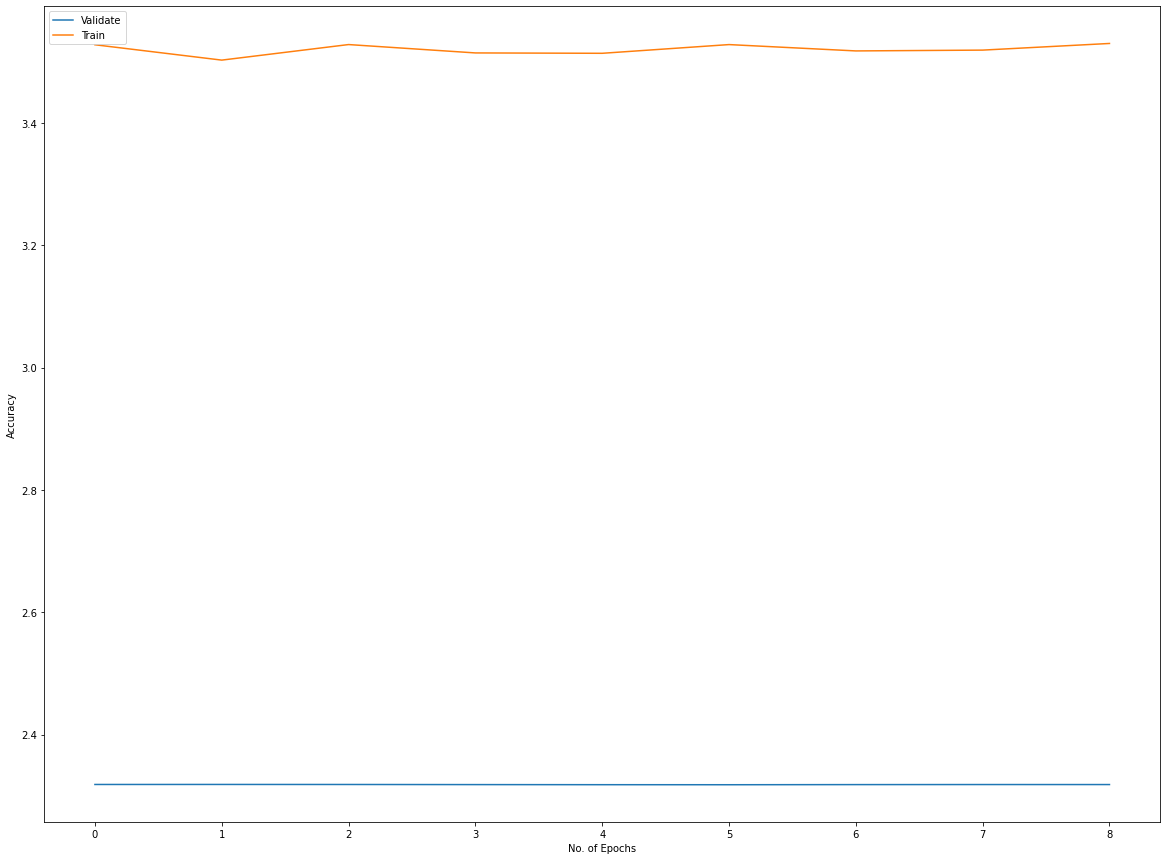

In [ ]:
print("The curves for losses of training data and validation data for p=0.75 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss3,label="Validate")
plt.plot(avg_training_loss3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for p=0.75 are :


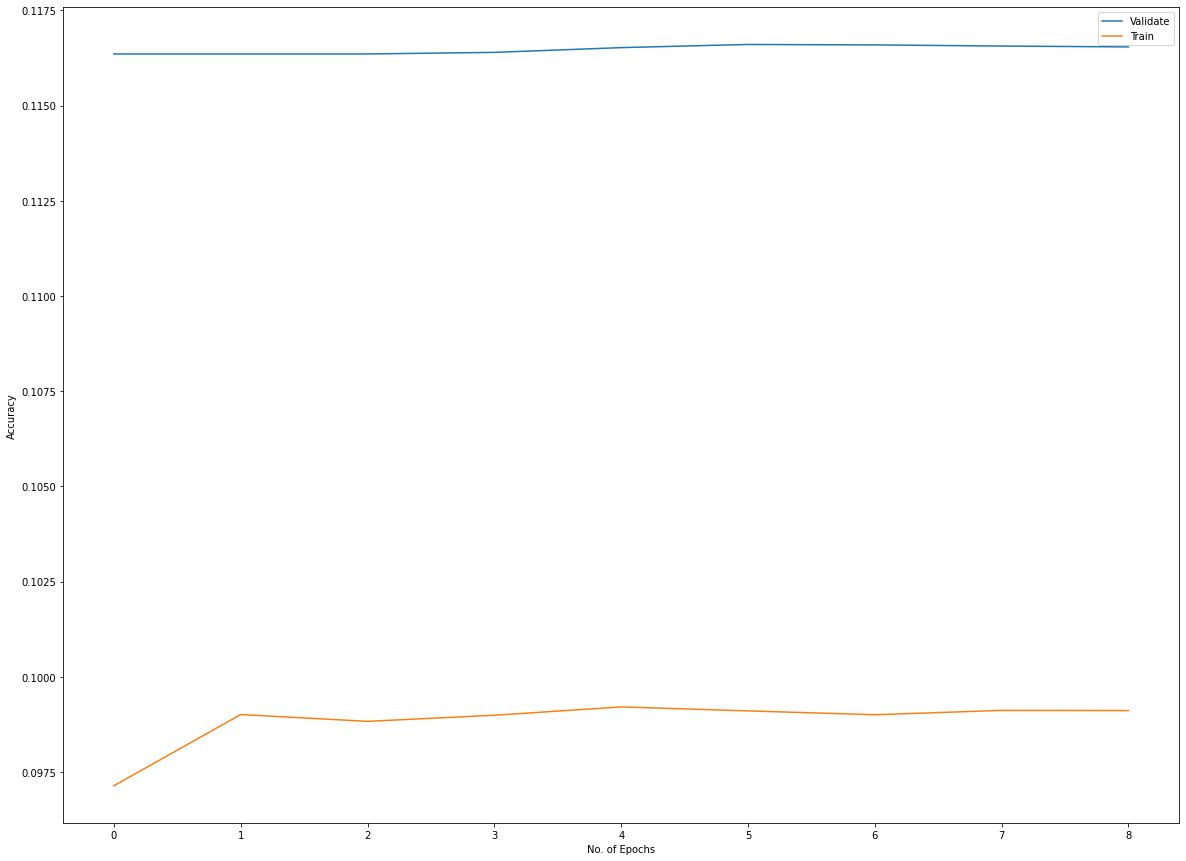

In [ ]:
print("The curves for accuracy of training data and validation data for p=0.75 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy3,label="Validate")
plt.plot(avg_training_accuracy3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We see that we are getting very low accuracies for values of p = 0.5 and p = 0.75.
So this time to get better results for our model we try inititializing the learning rate to 0.001

In [ ]:
model2 = CNN_Net(p=0.5)
model2.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer2 = optim.SGD(momentum=0.9,lr=0.001,params=model2.parameters())

lr_scheduler2 = optim.lr_scheduler.StepLR(optimizer=optimizer2 , step_size=10, gamma=0.1)

In [ ]:
print("Training the CNN Model for p = 0.5 with learning rate of 0.001:")
number_of_epochs = 15
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss2 = []
avg_training_accuracy2= []

avg_validation_loss2 = []
avg_validation_accuracy2 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model2.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer2.zero_grad()
        
        output = model2(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer2.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy2.append(np.mean(batch_accuracy))
    avg_training_loss2.append(training_loss/(i+1))
    
    model2.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model2(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy2.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss2.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model2.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler2.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy2)
    print("\nTraining Loss :",avg_training_loss2)
    
    print("\nValidation Accuracy :",avg_validation_accuracy2)
    print("\nValidation Loss :",avg_validation_loss2)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy2))
print("\nThe average training loss is :",np.mean(avg_training_loss2))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy2))
print("\nThe average validation loss is :",np.mean(avg_validation_loss2))

Training the CNN Model for p = 0.5 with learning rate of 0.001:
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.1122815462085308]

Training Loss : [2.301281384523446]

Validation Accuracy : [0.11336436170212766]

Validation Loss : [2.301609069743055]

Epoch is : 2

Training Accuracy : [0.1122815462085308, 0.1122815462085308]

Training Loss : [2.301281384523446, 2.301232519307973]

Validation Accuracy : [0.11336436170212766, 0.11336436170212766]

Validation Loss : [2.301609069743055, 2.301607167467158]

Epoch is : 3

Training Accuracy : [0.1122815462085308, 0.1122815462085308, 0.11228771721958926]

Training Loss : [2.301281384523446, 2.301232519307973, 2.3012347460075575]

Validation Accuracy : [0.11336436170212766, 0.11336436170212766, 0.11330895390070922]

Validation Loss : [2.301609069743055, 2.301607167467158, 2.3016772866249084]

Epoch is : 4

Training Accuracy : [0.1122815462085308, 0.1122815462085308, 0.11228771721

In [ ]:
model3 = CNN_Net(p=0.75)
model3.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer3 = optim.SGD(momentum=0.9,lr=0.001,params=model3.parameters())

lr_scheduler3 = optim.lr_scheduler.StepLR(optimizer=optimizer3 , step_size=10, gamma=0.1)

In [ ]:
print("Training the CNN Model for p = 0.75 with learning rate of 0.001:")
number_of_epochs = 15
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss3 = []
avg_training_accuracy3 = []

avg_validation_loss3 = []
avg_validation_accuracy3 = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model3.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer3.zero_grad()
        
        output = model3(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer3.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy3.append(np.mean(batch_accuracy))
    avg_training_loss3.append(training_loss/(i+1))
    
    model3.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model3(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy3.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss3.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model3.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler3.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy3)
    print("\nTraining Loss :",avg_training_loss3)
    
    print("\nValidation Accuracy :",avg_validation_accuracy3)
    print("\nValidation Loss :",avg_validation_loss3)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy3))
print("\nThe average training loss is :",np.mean(avg_training_loss3))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy3))
print("\nThe average validation loss is :",np.mean(avg_validation_loss3))

Training the CNN Model for p = 0.75 with learning rate of 0.001:
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.31088936611374407]

Training Loss : [1.900404738906718]

Validation Accuracy : [0.8066821808510638]

Validation Loss : [1.7437839108578703]

Epoch is : 2

Training Accuracy : [0.31088936611374407, 0.4427021623222749]

Training Loss : [1.900404738906718, 1.238787179839272]

Validation Accuracy : [0.8066821808510638, 0.808843085106383]

Validation Loss : [1.7437839108578703, 1.4753259515508692]

Epoch is : 3

Training Accuracy : [0.31088936611374407, 0.4427021623222749, 0.5072262539494471]

Training Loss : [1.900404738906718, 1.238787179839272, 1.066648233452397]

Validation Accuracy : [0.8066821808510638, 0.808843085106383, 0.8041334219858156]

Validation Loss : [1.7437839108578703, 1.4753259515508692, 1.3594617285627]

Epoch is : 4

Training Accuracy : [0.31088936611374407, 0.4427021623222749, 0.50722625394944

The curves for losses of training data and validation data for p=0.75 are :


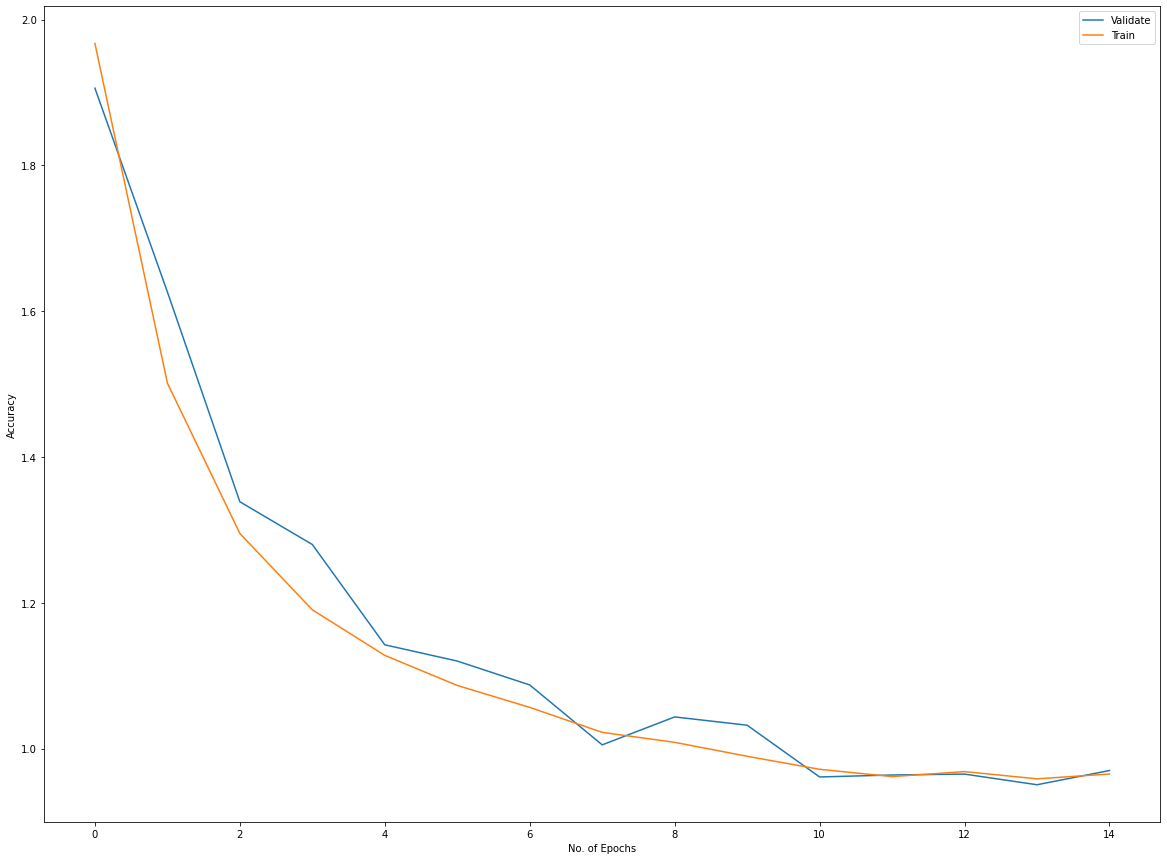

In [ ]:
print("The curves for losses of training data and validation data for p=0.75 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss3,label="Validate")
plt.plot(avg_training_loss3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The curves for accuracy of training data and validation data for p=0.75 are :


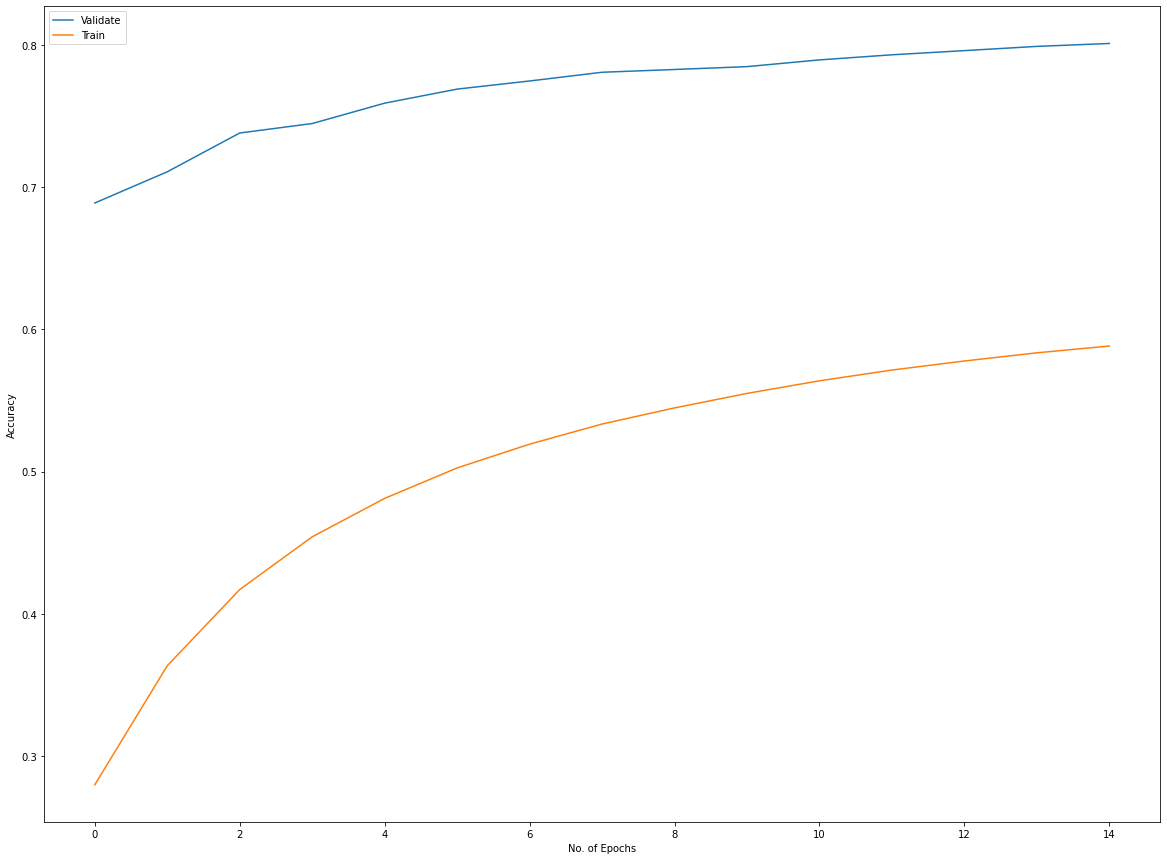

In [ ]:
print("The curves for accuracy of training data and validation data for p=0.75 are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy3,label="Validate")
plt.plot(avg_training_accuracy3,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Testing CNN Model for p=0.25:")
model1.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model1(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for p=0.25:

The accuracy after testing the CNN model is : 0.9912140575079872

The confusion matrix for test dataset is :
     0     1     2     3    4    5    6     7    8    9
0  977     0     0     0    0    0    1     1    1    0
1    0  1131     2     0    0    0    1     0    1    0
2    1     2  1023     1    1    0    0     3    1    0
3    0     0     2  1006    0    2    0     0    0    0
4    0     0     0     0  974    0    1     0    1    6
5    1     0     0     3    0  883    1     1    2    1
6    3     2     1     0    1    3  947     0    1    0
7    0     1     4     1    0    0    0  1018    1    3
8    2     0     1     2    1    1    0     2  962    3
9    1     0     0     1    6    4    0     4    2  991


In [ ]:
print("Testing CNN Model for p=0.5:")
model2.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model2(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for p=0.5:

The accuracy after testing the CNN model is : 0.10333466453674121

The confusion matrix for test dataset is :
   0  1     2  3  4  5  6  7  8  9
0  0  0   980  0  0  0  0  0  0  0
1  0  0  1135  0  0  0  0  0  0  0
2  0  0  1032  0  0  0  0  0  0  0
3  0  0  1010  0  0  0  0  0  0  0
4  0  0   982  0  0  0  0  0  0  0
5  0  0   892  0  0  0  0  0  0  0
6  0  0   958  0  0  0  0  0  0  0
7  0  0  1028  0  0  0  0  0  0  0
8  0  0   974  0  0  0  0  0  0  0
9  0  0  1009  0  0  0  0  0  0  0


In [ ]:
print("Testing CNN Model for p=0.75:")
model3.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model3(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model for p=0.75:

The accuracy after testing the CNN model is : 0.8325678913738019

The confusion matrix for test dataset is :
     0     1    2    3    4    5    6    7    8    9
0  807     0    0    0    0    0    3    0  170    0
1    0  1040    1    0    0    0    0    0   94    0
2    0     0  820    0    0    0    1    0  211    0
3    0     0    0  819    0    2    0    3  186    0
4    0     0    0    0  819    0    8    0   76   79
5    0     0    0    1    0  637    0    0  254    0
6    1     2    0    0    1    0  814    0  140    0
7    0     1   10    1    0    0    0  743  133  140
8    0     0    0    0    0    0    0    0  973    1
9    1     0    0    0    1    0    0    2  151  854


In this model, we have checked for three different values of p in our dropout layers which are: 0.25, 0.5 and 0.75. We have added a dropout layer after our activation layer in the same CNN architecture as the one used for baseline file.
First we initialized the learning rate 0.05 for all the values of p and then we trained our model. Using value of p as 0.25 we got a good accuracy on our training and validation data. We can see that from the learning curves for losses and accuracy and conclude that model fits reasonably well for p=0.25
However for p=0.5 and 0.75 we see that we are getting a very bad accuracy i.e. 10% on training and validation sets. In this case our model for both p values doesn't fit and there is underfitting of the model.
Then we tried changing the learning rate to 0.001 for both values of p and retrained the model. Now we can see that even though after changing the learning rate for p=0.5 the model is still not a reasonable fit and gives low accuracy, we get a improvement in accuracy for p=0.75 i.e. 58% on training and 80% on validation. From its learning curves, we see now this new model fits reasonably.
Using the best models, we run them on our test data and got:
1. Accuracy for p=0.25 : 99.10%
2. Accuracy for p=0.5 : 10.33%
3. Accuracy for p=0.75 : 83.25% 

### References Used:
1. www.pytorch.org/docs/stable/generated/torch.nn.Dropout.html

2. https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE